In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import  ImageDataGenerator

from scipy import ndimage, misc

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.metrics import roc_curve, auc

import os
import matplotlib.pyplot as plt

from keras.utils import to_categorical

from random import shuffle

PRÉ - PROCESSAMENTO

In [37]:
#caminho = os.getcwd()

#df = pd.read_csv(caminho +'/dataset_images_minitest.csv', sep='\t')

#dftrain = df.sample(round(len(df)*(0.7)))
#dftest = df.drop(dftrain.index)

#dftrain.to_csv(caminho +'/train.csv')
#dftest.to_csv(caminho +'/test.csv')

#file_namestrain = list(dftrain['filename'].values)
#img_labelstrain = list(dftrain['category'].values)

#file_namestest = list(dftest['filename'].values)
#img_labelstest = list(dftest['category'].values)


#pastasparacriar = np.unique(img_labelstrain) 

#for pasta in pastasparacriar:
 #   if not os.path.exists(caminho +'/data_folder/'+ pasta):
  #      os.makedirs(caminho +'/data_folder/'+pasta)

#os.makedirs(caminho +'/test') 

#test
#for f in range(len(file_namestest)):
#  current_img = file_namestest[f]
#  shutil.move(caminho +'/data_folder/' +current_img , caminho+ "/test")

#train
#for f in range(len(file_namestrain)):
#  current_img = file_namestrain[f]
#  current_label = img_labelstrain[f]
#  shutil.move(caminho +'/data_folder/' +current_img , caminho+ '/data_folder/' + current_label)




Função que embaralha imagens e etiquetas

In [2]:
def randomiza(X_test,y_test):

    listin=range(0,np.shape(X_test)[0])
    baralho=list(listin)
    shuffle(baralho)

    y_test2=[]
    X_test2=[]

    for i in baralho:
        y_test2.append(y_test[i])
        X_test2.append(X_test[i])

    y_test2=np.array(y_test2)
    X_test2=np.array(X_test2)
    
    return X_test2,y_test2

Uma função que carrega imagens para teste e uma para treino

a divisão de ambas veio de uma tentativa de usar data augmentation com flow from directory, por isso a classificação em pastas distintas do treino

In [3]:
def carrega_imagens_da_pasta_t(folder):
    images = []
    y_test=[]
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        imgfim = resize(img,(img_rows,img_cols))
        if np.shape(imgfim) == (img_rows,img_cols):
            continue
            #JOGA FORA AS PRETO E BRANCO
            imgfim = np.stack((imgfim, np.zeros((img_rows,img_cols)),np.zeros((img_rows,img_cols))),axis=2)
        if imgfim is not None:
            images.append(imgfim)
        
        caminho = os.getcwd()
        
        preytest = pd.read_csv(caminho + '/test.csv')
        
        y_test.append(preytest[preytest['filename']==filename]['category'].values[0]) 
        
    return images, y_test

def carrega_imagens_da_pasta(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        imgfim = resize(img,(img_rows,img_cols))
        if np.shape(imgfim) == (img_rows,img_cols):
            continue
            #JOGA FORA AS PRETO E BRANCO
            imgfim = np.stack((imgfim, np.zeros((img_rows,img_cols)),np.zeros((img_rows,img_cols))),axis=2)
        if imgfim is not None:
            images.append(imgfim)
    return images

Rotina que constrói X_test, y_test e X_train, y_train

In [6]:
img_rows, img_cols = 60, 60
num_classes=3

caminho = os.getcwd()

caminhograd= caminho +'/data_folder/graduation/'
caminhopic= caminho + '/data_folder/picnic/'
caminhomeeting= caminho + '/data_folder/meeting/'

caminhotest= caminho + '/test/'




grad =  carrega_imagens_da_pasta(caminhograd)

meet = carrega_imagens_da_pasta(caminhomeeting)

pic =  carrega_imagens_da_pasta(caminhopic)


y_train = len(grad)*[0]+len(meet)*[1]+len(pic)*[2]
y_train = to_categorical(y_train)


X_train = np.array(grad + meet + pic)

X_test , y_test = carrega_imagens_da_pasta_t(caminhotest)

X_test = np.array(X_test)



lista=[]

for i in range(0,len(y_test)):
    if y_test[i]=='graduation':
        lista.append(0)
    if y_test[i]=='meeting':
        lista.append(1)
    if y_test[i]=='picnic':
        lista.append(2)

y_test = np.array(y_test)        

y_test = to_categorical(lista)

X_train2 , y_train2 = randomiza(X_train,y_train)

X_test2 , y_test2 = randomiza(X_test,y_test)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


MODELO - CONVOLUCAO - MAXPOOLING, NO FINAL UMA CAMADA DENSA

In [7]:

model = Sequential()

model.add(Conv2D(100, kernel_size=5,
                 activation='relu',
                 input_shape=(img_rows, img_cols, 3)))

#model.add(MaxPooling2D((2,2)))

#model.add(Conv2D(50, kernel_size=5, activation='relu'))

model.add(MaxPooling2D((4,4)))

model.add(Dropout(0.2))

#model.add(BatchNormalization())



model.add(Conv2D(50, kernel_size=2, activation='relu'))

#model.add(Conv2D(100, kernel_size=2, activation='relu'))

model.add(MaxPooling2D(2, 2))

model.add(Dropout(0.2))


#model.add(Conv2D(100, kernel_size=5, activation='relu'))



model.add(Conv2D(50, kernel_size=5, activation='relu'))

#model.add(MaxPooling2D((4,4)))

model.add(Dropout(0.2))




model.add(Flatten())

model.add(Dense(200, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])




TREINANDO O MODELO

In [9]:
training=model.fit(X_train2,y_train2, validation_split=0.15, batch_size=50, epochs=5)

Train on 12473 samples, validate on 2202 samples
Epoch 1/5
12473/12473 [==============================] - 234s 19ms/step - loss: 1.0298 - acc: 0.4615 - val_loss: 0.9726 - val_acc: 0.5095
Epoch 2/5
12473/12473 [==============================] - 150s 12ms/step - loss: 0.9460 - acc: 0.5505 - val_loss: 0.9054 - val_acc: 0.5749
Epoch 3/5
12473/12473 [==============================] - 224s 18ms/step - loss: 0.8899 - acc: 0.5886 - val_loss: 0.8466 - val_acc: 0.6258
Epoch 4/5
12473/12473 [==============================] - 188s 15ms/step - loss: 0.8613 - acc: 0.6096 - val_loss: 0.8377 - val_acc: 0.6258
Epoch 5/5
12473/12473 [==============================] - 192s 15ms/step - loss: 0.8376 - acc: 0.6274 - val_loss: 0.8336 - val_acc: 0.6322


Salvando os pesos

In [10]:
model.save_weights('cincoepocas.h5')

In [ ]:
training10 = model.fit(X_train2,y_train2, validation_split=0.15, batch_size=100, epochs=10)

In [11]:
history = training.history
#history10 = training10.history

Evolução da função de loss com o treinamento 

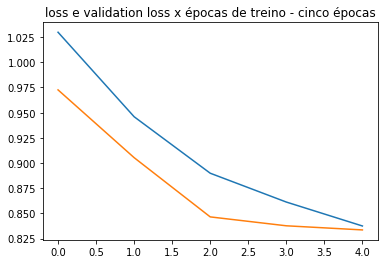

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss e validation loss x épocas de treino - cinco épocas')
plt.show()

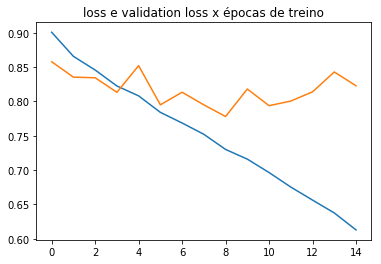

In [57]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss e validation loss x épocas de treino')
plt.show()

# Avaliando a performance do modelo

In [13]:
model.evaluate(X_test,y_test, batch_size=100)

6286/6286 [==============================] - 95s 15ms/step


[0.825446755974072, 0.6376073771588103]

In [14]:
model.evaluate(X_test,y_test)

6286/6286 [==============================] - 33s 5ms/step


[0.8254467641855933, 0.6376073815395527]

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [40]:
y_test[:,2]

array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)

Fazendo linhas roc e as medias correspondentes

In [21]:
def rocmedia(X_test, y_test, model):
    
    
    fpr_grad=[]
    
    tpr_grad=[]
    
    thresh_grad=[]
    
    
    fpr_meet=[]
    
    tpr_meet=[]
    
    thresh_meet=[]
    
    
    fpr_pic=[]
    
    tpr_pic=[]
    
    thresh_pic=[]
    
    

    
    auc_grad=[]
    
    auc_meet=[]
    
    auc_pic=[]
    
    
    for i in range(0,10):
        
        
        X_test2, y_test2 = randomiza(X_test , y_test)
        
        y_pred_keras = model.predict(X_test2)
        
    

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test2[:,0], y_pred_keras[:,0])
        
        
        fpr_grad.append(fpr_keras)

        tpr_grad.append(tpr_keras)
        
        thresh_grad.append(thresholds_keras)
        
        
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test2[:,0], y_pred_keras[:,1])
        
        fpr_meet.append(fpr_keras)

        tpr_meet.append(tpr_keras)
        
        thresh_meet.append(thresholds_keras)
        
        
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test2[:,0], y_pred_keras[:,2])
        
        
        fpr_pic.append(fpr_keras)

        tpr_pic.append(tpr_keras)


        thresh_pic.append(thresholds_keras)

        
        auc_grad.append( auc(fpr_grad[i], tpr_grad[i])  )
        
        auc_meet.append( auc(fpr_meet[i], tpr_meet[i]) )
        
        auc_pic.append( auc(fpr_pic[i], tpr_pic[i])   )
        
        
  
    return auc_grad, auc_meet, auc_pic, fpr_grad, tpr_grad, thresh_grad, fpr_meet, tpr_meet, thresh_meet, fpr_pic , tpr_pic, thresh_pic  

In [22]:
auc_grad, auc_meet, auc_pic, fpr_grad, tpr_grad, thresh_grad, fpr_meet, tpr_meet, thresh_meet, fpr_pic , tpr_pic, thresh_pic   = rocmedia(X_test, y_test, model)

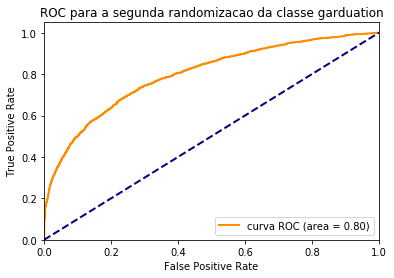

In [31]:
plt.figure()
lw = 2
plt.plot(fpr_grad[3], tpr_grad[3], color='darkorange',
         lw=lw, label='curva ROC (area = %0.2f)' % auc_grad[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC para a segunda randomizacao da classe garduation')
plt.legend(loc="lower right")
plt.show()

In [27]:
media_fpr_grad=np.zeros(np.shape(fpr_grad[1]))
media_fpr_meet=np.zeros(np.shape(fpr_meet[1]))
media_fpr_pic=np.zeros(np.shape(fpr_pic[1]))

media_tpr_grad=np.zeros(np.shape(tpr_grad[1]))
media_tpr_meet=np.zeros(np.shape(tpr_meet[1]))
media_tpr_pic=np.zeros(np.shape(tpr_pic[1]))

for i in range(0,10):
    
    media_fpr_grad += fpr_grad[i]/10
    media_fpr_meet += fpr_meet[i]/10
    media_fpr_pic += fpr_pic[i]/10
    
    media_tpr_grad += tpr_grad[i]/10
    media_tpr_meet += tpr_meet[i]/10
    media_tpr_pic += tpr_pic[i]/10
    


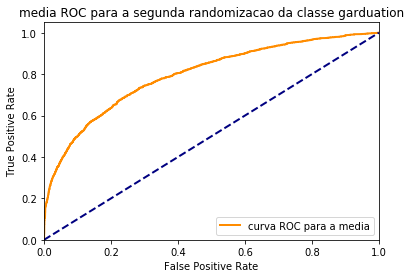

In [30]:
plt.figure()
lw = 2
plt.plot(media_fpr_grad, media_tpr_grad, color='darkorange',
         lw=lw, label='curva ROC para a media' )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('media ROC para a segunda randomizacao da classe garduation')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#model.compile(optimizer='adam', 
#              loss='categorical_crossentropy', 
#              metrics=['accuracy'])

# Fit the model to training data 
#model.fit(train_data, train_labels, 
#          validation_split=0.2, 
#          epochs=3, batch_size=10)

# Evaluate the model on test data
#

In [ ]:
#

#for im in grad:
#    a= np.shape(im)
#    if a != (50,50,3):
#        print(a)
#        im = np.stack((im , np.zeros((50,50)),np.zeros((50,50))),axis=2)
#        a= np.shape(im)
#        print(a)
#        break

In [ ]:
     # media_fpr_grad += fpr_grad[i]
        #media_tpr_grad += tpr_grad[i]
        #media_thresh_grad += thresh_grad[i]
    
       # media_fpr_meet += fpr_meet[i]
       # media_tpr_meet += tpr_meet[i]
        #media_thresh_meet += thresh_meet[i]
        
       # media_fpr_pic += fpr_pic[i]
      #  media_tpr_pic += tpr_pic[i]
     #   media_thresh_pic += thresh_pic[i]
    
    
    
    #media_fpr_grad = media_fpr_grad/10
    #media_tpr_grad =  media_tpr_grad/10
    #media_thresh_grad = media_thresh_grad/10
    
    #media_fpr_meet = media_fpr_meet/10
    #media_tpr_meet =  media_tpr_meet/10
    #media_thresh_meet = media_thresh_meet/10
    
    #media_fpr_pic = media_fpr_pic/10
    #media_tpr_pic =  media_tpr_pic/10
    #media_thresh_pic = media_thresh_pic/10
    

        
        
    